#install important packages

In [35]:
#pip install tensorflow sklearn pandas numpy matplotlib nltk

#import python packages

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import io
import nltk
import json
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input, Embedding, LSTM , Dense,GlobalAveragePooling1D,Flatten, Dropout , GRU
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Conv1D, MaxPool1D
from glob import glob


2023-04-21 13:10:01.663153: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


#Read dataset as json file

In [2]:
files = glob('../data/*', recursive=True)
datasets=[]
for single_file in files:
    with open(single_file, 'r') as f:
        dataset = json.load(f)
        datasets.append(dataset)

In [3]:
def processing_json_dataset(dataset):
  tags = []
  inputs = []
  responses={}
  for intent in dataset['intents']:
    responses[intent['intent']]=intent['responses']
    for lines in intent['text']:
      inputs.append(lines)
      tags.append(intent['intent'])
  return [tags, inputs, responses]

In [4]:
tags = []
inputs = []
responses={}

for dataset in datasets:

    [tags_list, inputs_list, responses_dict] = processing_json_dataset(dataset)
    tags=tags+tags_list
    inputs=inputs+inputs_list
    responses.update(responses_dict)
    

#dataset as DataFrame

In [5]:
dataset = pd.DataFrame({"inputs":inputs,
                     "tags":tags})

In [6]:
dataset.tail()

,inputs,tags
446,Is it possible to reschedule my appointment an...,RescheduleAppointment
447,Can I reschedule my appointment and receive a ...,RescheduleAppointment
448,"I'd like to reschedule my appointment, can you...",RescheduleAppointment
449,"I need to reschedule my appointment, but I'm n...",RescheduleAppointment
450,Can you please assist me with rescheduling my ...,RescheduleAppointment


In [7]:
dataset = dataset.sample(frac=1)

In [8]:
dataset.head()

,inputs,tags
185,what to do if i get a Fracture?,Fracture
243,OK thank you,Thanks
285,Cheerio,CourtesyGoodBye
341,"I won't be able to make my appointment, can I ...",CancelAppointment
47,How to cure sore throat?,Sore Throat


#Pre-processing text of dataset

In [9]:
import string
dataset['inputs'] = dataset['inputs'].apply(lambda sequence:
                                            [ltrs.lower() for ltrs in sequence if ltrs not in string.punctuation])

In [10]:
dataset.head()

,inputs,tags
185,"[w, h, a, t, , t, o, , d, o, , i, f, , i, ...",Fracture
243,"[o, k, , t, h, a, n, k, , y, o, u]",Thanks
285,"[c, h, e, e, r, i, o]",CourtesyGoodBye
341,"[i, , w, o, n, t, , b, e, , a, b, l, e, , ...",CancelAppointment
47,"[h, o, w, , t, o, , c, u, r, e, , s, o, r, ...",Sore Throat


In [11]:
dataset['inputs'] = dataset['inputs'].apply(lambda wrd: ''.join(wrd))

In [12]:
dataset.head()

,inputs,tags
185,what to do if i get a fracture,Fracture
243,ok thank you,Thanks
285,cheerio,CourtesyGoodBye
341,i wont be able to make my appointment can i ca...,CancelAppointment
47,how to cure sore throat,Sore Throat


In [13]:
tokenizer = Tokenizer(num_words=1000)
tokenizer.fit_on_texts(dataset['inputs'])
train = tokenizer.texts_to_sequences(dataset['inputs'])
features = pad_sequences(train)
le = LabelEncoder()
labels = le.fit_transform(dataset['tags'])

In [14]:
len(features[0])

17

In [15]:
input_shape = features.shape[1]
print(input_shape)

17


In [16]:
features.shape

(451, 17)

In [17]:
vocabulary = len(tokenizer.word_index)
print("number of unique words : ",vocabulary)
output_length = le.classes_.shape[0]
print("output length: ",output_length)

number of unique words :  332
output length:  51


In [18]:
tokenizer.word_index

{'to': 1,
 'i': 2,
 'a': 3,
 'appointment': 4,
 'you': 5,
 'my': 6,
 'do': 7,
 'how': 8,
 'if': 9,
 'reschedule': 10,
 'can': 11,
 'get': 12,
 'what': 13,
 'which': 14,
 'treat': 15,
 'it': 16,
 'medicine': 17,
 'take': 18,
 'need': 19,
 'cancel': 20,
 'cure': 21,
 'like': 22,
 'for': 23,
 'id': 24,
 'im': 25,
 'and': 26,
 'make': 27,
 'an': 28,
 'me': 29,
 'the': 30,
 'have': 31,
 'please': 32,
 'with': 33,
 'but': 34,
 'are': 35,
 'time': 36,
 'bite': 37,
 'is': 38,
 'book': 39,
 'different': 40,
 'thanks': 41,
 'hows': 42,
 'bleeding': 43,
 'of': 44,
 'thank': 45,
 'be': 46,
 'help': 47,
 'confirmation': 48,
 'schedule': 49,
 'possible': 50,
 'not': 51,
 'sure': 52,
 'there': 53,
 'broken': 54,
 'new': 55,
 'burn': 56,
 'pain': 57,
 'mild': 58,
 'your': 59,
 'apply': 60,
 'in': 61,
 'we': 62,
 'day': 63,
 'wont': 64,
 'able': 65,
 'whats': 66,
 'heat': 67,
 'email': 68,
 'one': 69,
 'up': 70,
 'that': 71,
 'sorry': 72,
 'nose': 73,
 'later': 74,
 'date': 75,
 'see': 76,
 'abrasions'

#RNN MODEL

## Build RNN Model

In [19]:
'''m = Sequential()
m.add(Input(shape=(features.shape[1])))
m.add(Embedding(vocabulary + 1,100))
m.add(Conv1D(filters=32, kernel_size=5, activation="relu", kernel_initializer=tf.keras.initializers.GlorotNormal(),bias_regularizer=tf.keras.regularizers.L2(0.0001), kernel_regularizer=tf.keras.regularizers.L2(0.0001), activity_regularizer = tf.keras.regularizers.L2(0.0001))) 
m.add(Dropout(0.3))
m.add(LSTM(32, dropout=0.3,return_sequences=True))
m.add(LSTM(16, dropout=0.3,return_sequences=False))
m.add(Dense(128,activation="relu", activity_regularizer = tf.keras.regularizers.L2(0.0001))) 
m.add(Dropout(0.6))
m.add(Dense(output_length, activation="softmax", activity_regularizer = tf.keras.regularizers.L2(0.0001))) '''

# BI LSTM
m= tf.keras.models.Sequential([
    tf.keras.layers.Embedding(vocabulary + 1, 100),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, dropout=0.2)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(output_length, activation='softmax')
])


2023-04-21 13:10:11.810286: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [20]:
'''# build RNN Model with tensorflow
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(vocab_size, embed_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units, dropout=0.2)),
    tf.keras.layers.Dense(units, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(target_length, activation='softmax')
])

optimizer = tf.keras.optimizers.Adam(lr=1e-2)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()'''

"# build RNN Model with tensorflow\nmodel = tf.keras.models.Sequential([\n    tf.keras.layers.Embedding(vocab_size, embed_dim),\n    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units, dropout=0.2)),\n    tf.keras.layers.Dense(units, activation='relu'),\n    tf.keras.layers.Dropout(0.5),\n    tf.keras.layers.Dense(target_length, activation='softmax')\n])\n\noptimizer = tf.keras.optimizers.Adam(lr=1e-2)\nmodel.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])\nmodel.summary()"

In [24]:
m.layers

In [26]:
glove_dir = "glove.6B.100d.txt"
embeddings_index = {}
file_ = open(glove_dir)
for line in file_:
    arr = line.split()
    single_word = arr[0]
    w = np.asarray(arr[1:],dtype='float32')
    embeddings_index[single_word] = w
file_.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [27]:
max_words = vocabulary + 1
word_index = tokenizer.word_index
embedding_matrix = np.zeros((max_words,100)).astype(object)
for word , i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [28]:
m.layers[0].set_weights([embedding_matrix])
m.layers[0].trainable = False


In [29]:
m.compile(loss="sparse_categorical_crossentropy",optimizer='adam',metrics=['accuracy'])

In [30]:
m.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         33300     
                                                                 
 bidirectional (Bidirectiona  (None, 256)              234496    
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 51)                6579      
                                                                 
Total params: 307,271
Trainable params: 273,971
Non-trainable params: 33,300
_____________________________________________

In [31]:
from keras.callbacks import TensorBoard, EarlyStopping
earlyStopping = EarlyStopping(monitor = 'loss', patience = 200, mode = 'min', restore_best_weights = True)

In [32]:
from sklearn.metrics import f1_score
import numpy as np

class F1ScoreCallback(tf.keras.callbacks.Callback):
    def __init__(self, X_val, y_val):
        self.X_val = X_val
        self.y_val = y_val
        self.f1_scores = []

    def on_epoch_end(self, epoch, logs=None):
        y_pred = self.model.predict(self.X_val)
        y_pred = np.argmax(y_pred, axis=1)
        f1 = f1_score(self.y_val, y_pred, average='weighted')
        self.f1_scores.append(f1)
        print(f'F1 score: {f1}')

# create the callback and pass it to the fit method
f1_callback = F1ScoreCallback(features, labels)
history = m.fit(features, labels, epochs=60, batch_size=64, callbacks=[earlyStopping, f1_callback])


Epoch 1/60
15/15 [==============================] - 1s 6ms/steps: 3.8312 - accuracy: 0.1
F1 score: 0.057304646831961285
8/8 [==============================] - 6s 192ms/step - loss: 3.8135 - accuracy: 0.1109
Epoch 2/60
15/15 [==============================] - 0s 5ms/steps: 3.4360 - accuracy: 0.
F1 score: 0.07840384292484805
8/8 [==============================] - 0s 38ms/step - loss: 3.4385 - accuracy: 0.1685
Epoch 3/60
15/15 [==============================] - 0s 5ms/steps: 3.2117 - accuracy: 0.
F1 score: 0.13277023384668404
8/8 [==============================] - 0s 39ms/step - loss: 3.2155 - accuracy: 0.2106
Epoch 4/60
15/15 [==============================] - 0s 6ms/steps: 3.0401 - accuracy: 0.
F1 score: 0.16002431098785277
8/8 [==============================] - 0s 41ms/step - loss: 2.9966 - accuracy: 0.2373
Epoch 5/60
15/15 [==============================] - 0s 5ms/steps: 2.7775 - accuracy: 0.
F1 score: 0.24175641874725234
8/8 [==============================] - 0s 42ms/step - loss: 2.7

15/15 [==============================] - 0s 7ms/steps: 0.4851 - accuracy: 0.
F1 score: 0.9782215432239109
8/8 [==============================] - 0s 51ms/step - loss: 0.4861 - accuracy: 0.8581
Epoch 42/60
15/15 [==============================] - 0s 6ms/steps: 0.4201 - accuracy: 0.
F1 score: 0.971185219114416
8/8 [==============================] - 0s 48ms/step - loss: 0.4298 - accuracy: 0.8914
Epoch 43/60
15/15 [==============================] - 0s 6ms/steps: 0.4958 - accuracy: 0.
F1 score: 0.9559422779362717
8/8 [==============================] - 0s 46ms/step - loss: 0.4958 - accuracy: 0.8470
Epoch 44/60
15/15 [==============================] - 0s 6ms/steps: 0.4502 - accuracy: 0.
F1 score: 0.9761136663752081
8/8 [==============================] - 0s 45ms/step - loss: 0.4456 - accuracy: 0.8847
Epoch 45/60
15/15 [==============================] - 0s 7ms/steps: 0.4174 - accuracy: 0.
F1 score: 0.9775775960991288
8/8 [==============================] - 0s 49ms/step - loss: 0.4167 - accuracy: 

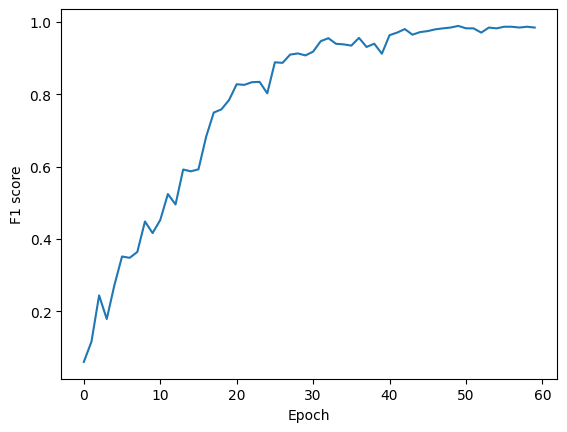

In [66]:
import matplotlib.pyplot as plt

plt.plot(f1_callback.f1_scores)
plt.xlabel('Epoch')
plt.ylabel('F1 score')
plt.show()


In [33]:
from sklearn.metrics import roc_auc_score

y_pred = m.predict(features)
y_true_onehot = tf.keras.utils.to_categorical(labels)

roc_auc = roc_auc_score(y_true_onehot, y_pred, multi_class='ovo')
print(f'ROC AUC score: {roc_auc}')


15/15 [==============================] - 0s 10ms/step
ROC AUC score: 0.999921332108382


In [35]:
from sklearn.model_selection import train_test_split
from scipy.stats import ks_2samp

# Split dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(features, labels, test_size=0.2, random_state=42)

# Train your model on the training set
m.fit(X_train, y_train, epochs=60, batch_size=64, callbacks=[earlyStopping])

# Predict the probabilities of the validation set instances belonging to the positive class
y_pred = m.predict(X_val)[:, 1]

# Calculate the empirical CDF of predicted probabilities and true labels
y_pred_sorted = np.sort(y_pred)
y_val_sorted = np.sort(y_val)
cdf_pred = np.linspace(0, 1, len(y_pred), endpoint=True)
cdf_true = np.linspace(0, 1, len(y_val), endpoint=True)

# Calculate the KS statistic
ks_stat, p_value = ks_2samp(cdf_pred, cdf_true)

# Check if the KS statistic is below the threshold
ks_threshold = 0.1
while ks_stat < ks_threshold:
    # Retrain the model with additional epochs or adjust the model architecture
    m.fit(X_train, y_train, epochs=5, batch_size=32)
    y_pred = m.predict(X_val)[:, 1]
    y_pred_sorted = np.sort(y_pred)
    cdf_pred = np.linspace(0, 1, len(y_pred), endpoint=True)
    ks_stat, p_value = ks_2samp(cdf_pred, cdf_true)

Epoch 1/60
6/6 [==============================] - 0s 31ms/step - loss: 0.0369 - accuracy: 0.9917
Epoch 2/60
6/6 [==============================] - 0s 23ms/step - loss: 0.0481 - accuracy: 0.9750
Epoch 3/60
6/6 [==============================] - 0s 23ms/step - loss: 0.0438 - accuracy: 0.9861
Epoch 4/60
6/6 [==============================] - 0s 24ms/step - loss: 0.0385 - accuracy: 0.9861
Epoch 5/60
6/6 [==============================] - 0s 22ms/step - loss: 0.0550 - accuracy: 0.9806
Epoch 6/60
6/6 [==============================] - 0s 23ms/step - loss: 0.0463 - accuracy: 0.9861
Epoch 7/60
6/6 [==============================] - 0s 21ms/step - loss: 0.0423 - accuracy: 0.9889
Epoch 8/60
6/6 [==============================] - 0s 21ms/step - loss: 0.0374 - accuracy: 0.9944
Epoch 9/60
6/6 [==============================] - 0s 21ms/step - loss: 0.0418 - accuracy: 0.9889
Epoch 10/60
6/6 [==============================] - 0s 21ms/step - loss: 0.0529 - accuracy: 0.9833
Epoch 11/60
6/6 [============

12/12 [==============================] - 0s 17ms/step - loss: 0.0325 - accuracy: 0.9861
Epoch 3/5
12/12 [==============================] - 0s 15ms/step - loss: 0.0282 - accuracy: 0.9889
Epoch 4/5
12/12 [==============================] - 0s 15ms/step - loss: 0.0308 - accuracy: 0.9833
Epoch 5/5
3/3 [==============================] - 0s 8ms/step
Epoch 1/5
12/12 [==============================] - 0s 19ms/step - loss: 0.0399 - accuracy: 0.9778
Epoch 2/5
12/12 [==============================] - 0s 15ms/step - loss: 0.0482 - accuracy: 0.9861
Epoch 3/5
12/12 [==============================] - 0s 15ms/step - loss: 0.0294 - accuracy: 0.9889
Epoch 4/5
12/12 [==============================] - 0s 15ms/step - loss: 0.0328 - accuracy: 0.9861
Epoch 5/5
3/3 [==============================] - 0s 7ms/step
Epoch 1/5
12/12 [==============================] - 0s 16ms/step - loss: 0.0303 - accuracy: 0.9889
Epoch 2/5
12/12 [==============================] - 0s 15ms/step - loss: 0.0606 - accuracy: 0.9806
Epoch 

12/12 [==============================] - 0s 17ms/step - loss: 0.0217 - accuracy: 0.9833
Epoch 3/5
12/12 [==============================] - 0s 16ms/step - loss: 0.0193 - accuracy: 0.9889
Epoch 4/5
12/12 [==============================] - 0s 15ms/step - loss: 0.0270 - accuracy: 0.9833
Epoch 5/5
3/3 [==============================] - 0s 6ms/step
Epoch 1/5
12/12 [==============================] - 0s 15ms/step - loss: 0.0377 - accuracy: 0.9806
Epoch 2/5
12/12 [==============================] - 0s 16ms/step - loss: 0.0255 - accuracy: 0.9889
Epoch 3/5
12/12 [==============================] - 0s 16ms/step - loss: 0.0238 - accuracy: 0.9889
Epoch 4/5
12/12 [==============================] - 0s 16ms/step - loss: 0.0224 - accuracy: 0.9833
Epoch 5/5
3/3 [==============================] - 0s 7ms/step
Epoch 1/5
12/12 [==============================] - 0s 16ms/step - loss: 0.0218 - accuracy: 0.9889
Epoch 2/5
12/12 [==============================] - 0s 19ms/step - loss: 0.0200 - accuracy: 0.9917
Epoch 

12/12 [==============================] - 0s 22ms/step - loss: 0.0254 - accuracy: 0.9833
Epoch 3/5
12/12 [==============================] - 0s 20ms/step - loss: 0.0249 - accuracy: 0.9861
Epoch 4/5
12/12 [==============================] - 0s 23ms/step - loss: 0.0193 - accuracy: 0.9861
Epoch 5/5
3/3 [==============================] - 0s 10ms/step
Epoch 1/5
12/12 [==============================] - 0s 25ms/step - loss: 0.0215 - accuracy: 0.9889
Epoch 2/5
12/12 [==============================] - 0s 22ms/step - loss: 0.0194 - accuracy: 0.9917
Epoch 3/5
12/12 [==============================] - 0s 30ms/step - loss: 0.0185 - accuracy: 0.9861
Epoch 4/5
12/12 [==============================] - 0s 20ms/step - loss: 0.0205 - accuracy: 0.9889
Epoch 5/5
3/3 [==============================] - 0s 11ms/step
Epoch 1/5
12/12 [==============================] - 0s 24ms/step - loss: 0.0205 - accuracy: 0.9917
Epoch 2/5
12/12 [==============================] - 0s 24ms/step - loss: 0.0201 - accuracy: 0.9917
Epoc

12/12 [==============================] - 0s 23ms/step - loss: 0.0477 - accuracy: 0.9778
Epoch 3/5
12/12 [==============================] - 0s 21ms/step - loss: 0.0733 - accuracy: 0.9778
Epoch 4/5
12/12 [==============================] - 0s 27ms/step - loss: 0.0299 - accuracy: 0.9944
Epoch 5/5
3/3 [==============================] - 0s 10ms/step
Epoch 1/5
12/12 [==============================] - 0s 27ms/step - loss: 0.0185 - accuracy: 0.9889
Epoch 2/5
12/12 [==============================] - 0s 23ms/step - loss: 0.0269 - accuracy: 0.9806
Epoch 3/5
12/12 [==============================] - 0s 23ms/step - loss: 0.0152 - accuracy: 0.9972
Epoch 4/5
12/12 [==============================] - 0s 23ms/step - loss: 0.0206 - accuracy: 0.9889
Epoch 5/5
3/3 [==============================] - 0s 10ms/step
Epoch 1/5
12/12 [==============================] - 0s 26ms/step - loss: 0.0160 - accuracy: 0.9917
Epoch 2/5
12/12 [==============================] - 0s 22ms/step - loss: 0.0180 - accuracy: 0.9833
Epoc

12/12 [==============================] - 0s 20ms/step - loss: 0.0365 - accuracy: 0.9889
Epoch 3/5
12/12 [==============================] - 0s 18ms/step - loss: 0.0354 - accuracy: 0.9861
Epoch 4/5
12/12 [==============================] - 0s 19ms/step - loss: 0.0343 - accuracy: 0.9889
Epoch 5/5
3/3 [==============================] - 0s 8ms/step
Epoch 1/5
12/12 [==============================] - 0s 27ms/step - loss: 0.0290 - accuracy: 0.9806
Epoch 2/5
12/12 [==============================] - 0s 23ms/step - loss: 0.0180 - accuracy: 0.9889
Epoch 3/5
12/12 [==============================] - 0s 19ms/step - loss: 0.0257 - accuracy: 0.9833
Epoch 4/5
12/12 [==============================] - 0s 19ms/step - loss: 0.0208 - accuracy: 0.9889
Epoch 5/5
3/3 [==============================] - 0s 9ms/step
Epoch 1/5
12/12 [==============================] - 0s 19ms/step - loss: 0.0204 - accuracy: 0.9833
Epoch 2/5
12/12 [==============================] - 0s 19ms/step - loss: 0.0182 - accuracy: 0.9861
Epoch 

12/12 [==============================] - 0s 18ms/step - loss: 0.0199 - accuracy: 0.9861
Epoch 3/5
12/12 [==============================] - 0s 18ms/step - loss: 0.0176 - accuracy: 0.9889
Epoch 4/5
12/12 [==============================] - 0s 17ms/step - loss: 0.0179 - accuracy: 0.9833
Epoch 5/5
3/3 [==============================] - 0s 10ms/step
Epoch 1/5
12/12 [==============================] - 0s 19ms/step - loss: 0.0178 - accuracy: 0.9889
Epoch 2/5
12/12 [==============================] - 0s 20ms/step - loss: 0.0151 - accuracy: 0.9889
Epoch 3/5
12/12 [==============================] - 0s 20ms/step - loss: 0.0167 - accuracy: 0.9889
Epoch 4/5
12/12 [==============================] - 0s 23ms/step - loss: 0.0165 - accuracy: 0.9889
Epoch 5/5
3/3 [==============================] - 0s 10ms/step
Epoch 1/5
12/12 [==============================] - 0s 26ms/step - loss: 0.0193 - accuracy: 0.9889
Epoch 2/5
12/12 [==============================] - 0s 23ms/step - loss: 0.0171 - accuracy: 0.9889
Epoc

12/12 [==============================] - 0s 18ms/step - loss: 0.0165 - accuracy: 0.9889
Epoch 3/5
12/12 [==============================] - 0s 18ms/step - loss: 0.0177 - accuracy: 0.9889
Epoch 4/5
12/12 [==============================] - 0s 17ms/step - loss: 0.0153 - accuracy: 0.9944
Epoch 5/5
3/3 [==============================] - 0s 8ms/step
Epoch 1/5
12/12 [==============================] - 0s 17ms/step - loss: 0.0179 - accuracy: 0.9861
Epoch 2/5
12/12 [==============================] - 0s 17ms/step - loss: 0.0150 - accuracy: 0.9917
Epoch 3/5
12/12 [==============================] - 0s 17ms/step - loss: 0.0162 - accuracy: 0.9917
Epoch 4/5
12/12 [==============================] - 0s 29ms/step - loss: 0.0196 - accuracy: 0.9889
Epoch 5/5
3/3 [==============================] - 0s 8ms/step
Epoch 1/5
12/12 [==============================] - 0s 17ms/step - loss: 0.0164 - accuracy: 0.9917
Epoch 2/5
12/12 [==============================] - 0s 17ms/step - loss: 0.0179 - accuracy: 0.9833
Epoch 

KeyboardInterrupt: 

In [65]:
m.save_weights("model.h5")

In [30]:
import matplotlib as mpl
def draw_plot(data, type_data):
  mpl.style.use('seaborn')
  plt.figure(figsize = (25, 5))
  plt.plot(data,'darkorange', label='Train')
  plt.xlabel('Epoch')
  plt.ylabel(type_data)
  plt.legend()

/var/folders/8s/kbp6s5q974s_8vdkmdh3kwhc0000gp/T/ipykernel_7936/3172170717.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  mpl.style.use('seaborn')


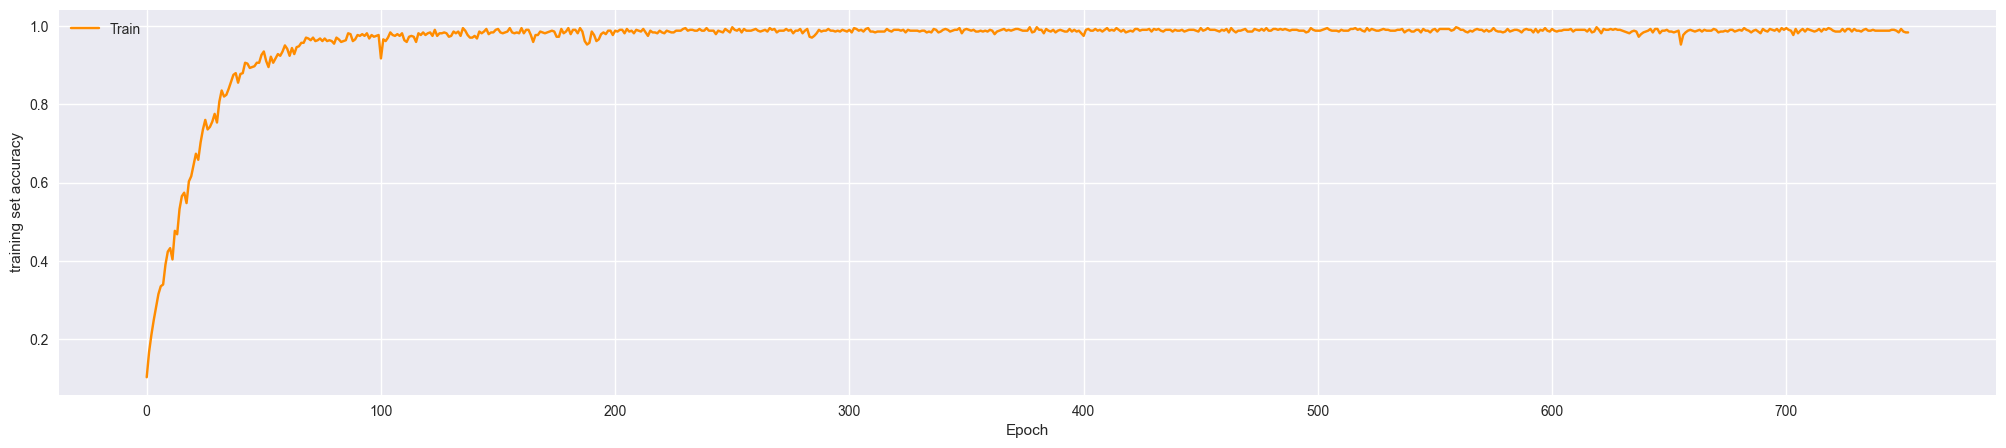

In [31]:
draw_plot(history_training.history['accuracy'],'training set accuracy' )

In [ ]:
history_training = m.fit(features,labels,epochs=2000, batch_size=64, callbacks=[ earlyStopping])

/var/folders/8s/kbp6s5q974s_8vdkmdh3kwhc0000gp/T/ipykernel_7936/3172170717.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  mpl.style.use('seaborn')


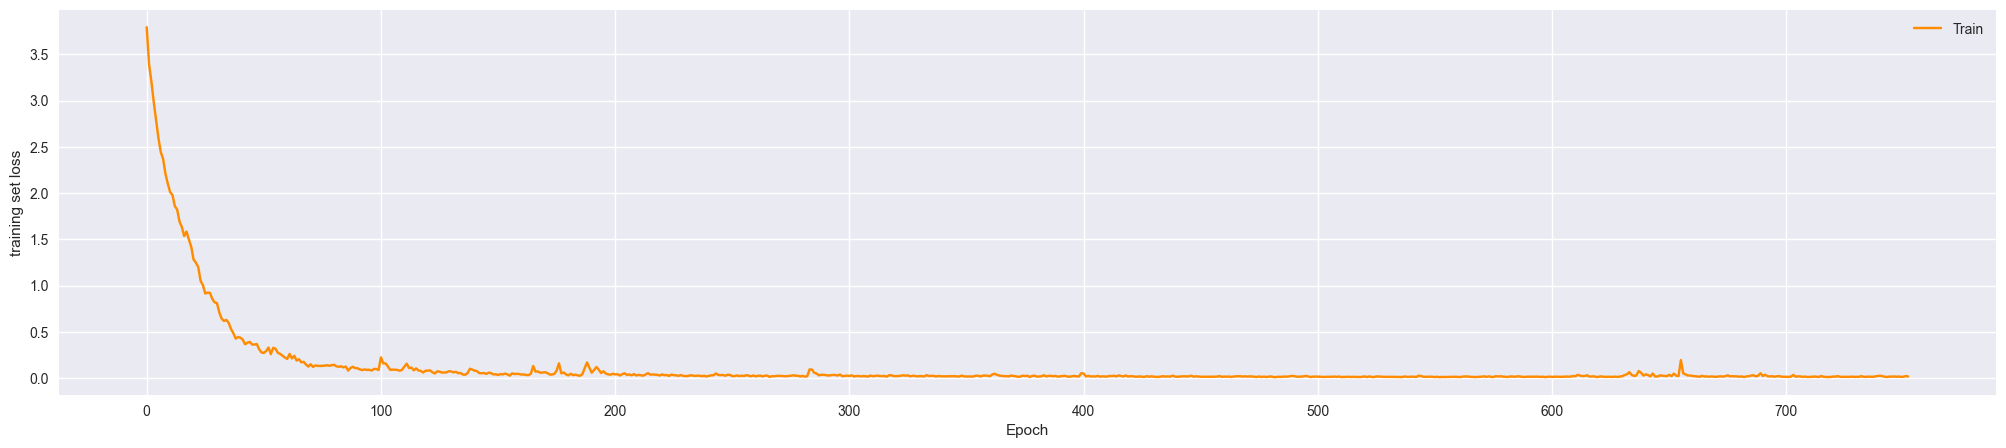

In [32]:
draw_plot(history_training.history['loss'],'training set loss' )

In [33]:
m.evaluate(features, labels, batch_size = 64)

8/8 [==============================] - 1s 13ms/step - loss: 0.0125 - accuracy: 0.9911


[0.012530329637229443, 0.9911308288574219]

## Testing

In [82]:
import random
def generate_answer(query):
  texts = []
  pred_input = query
  pred_input = [letters.lower() for letters in pred_input if letters not in string.punctuation]
  pred_input = ''.join(pred_input)
  texts.append(pred_input)
  pred_input = tokenizer.texts_to_sequences(texts)
  pred_input = np.array(pred_input).reshape(-1)
  pred_input = pad_sequences([pred_input],input_shape)
  output = m.predict(pred_input)
  print(output[0][output.argmax()])
  if (output[0][output.argmax()]) < 0.7 :
    return "I cant help you with this ", "INVALID"
  output = output.argmax()
  
  response_tag = le.inverse_transform([output])[0]
  return random.choice(responses[response_tag]),response_tag

In [83]:
list_que = ["hello", "please book an appointment","Can you cancel the appointment?",
            "I want to reschedule the appointment please",
            "how to cure cough", "please help me with  heart attack","i am suffering from head pain "]
for i in list_que:
  print("you: {}".format(i))
  #res_tag, intent = generate_answer(i)
  print(generate_answer(i))  

you: hello
1/1 [==============================] - 0s 27ms/step
0.79041934
('Hello how can I help you', 'Greeting')
you: please book an appointment
1/1 [==============================] - 0s 26ms/step
0.9997451
('No problem, I can definitely arrange an appointment for you. Please tell me your name and email id', 'BookAppointment')
you: Can you cancel the appointment?
1/1 [==============================] - 0s 21ms/step
0.9973763
('No problem, Please tell me your  email id', 'CancelAppointment')
you: I want to reschedule the appointment please
1/1 [==============================] - 0s 25ms/step
0.99966514
('Certainly, Please tell me your email id', 'RescheduleAppointment')
you: how to cure cough
1/1 [==============================] - 0s 25ms/step
0.98610663
('1) Honey:- Use honey to treat a cough, mix 2 teaspoons (tsp) with warm water or an herbal tea. Drink this mixture once or twice a day. Do not give honey to children under 1 year of age. 2) Ginger:- Brew up a soothing ginger tea by add